In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import BatchNormalization, Activation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

import shutil
from sklearn.model_selection import train_test_split

import os

In [8]:
# Define your directories
vehicle_dir = 'C:/Users/abbie/Documents/Deep Learning/Vehicle Classification/data/vehicles'
non_vehicle_dir = 'C:/Users/abbie/Documents/Deep Learning/Vehicle Classification/data/non-vehicles'

# Function to get file paths
def get_file_paths(directory):
    return [os.path.join(directory, f) for f in os.listdir(directory)]

# Get file paths
vehicle_files = get_file_paths(vehicle_dir)
non_vehicle_files = get_file_paths(non_vehicle_dir)

# Combine and label data (1 for vehicle, 0 for non-vehicle)
X = vehicle_files + non_vehicle_files
y = np.array([1] * len(vehicle_files) + [0] * len(non_vehicle_files))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Convert labels to strings for compatibility
y_train_str = [str(label) for label in y_train]
y_test_str = [str(label) for label in y_test]

In [10]:
# Creating DataFrames for training and validation
train_df = pd.DataFrame({'filename': X_train, 'class': y_train_str})
validation_df = pd.DataFrame({'filename': X_test, 'class': y_test_str})

In [11]:
# ImageDataGenerator for training (with augmentation) and validation (without augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
# Define target size
target_size = (64, 64)
batch_size = 32

# Creating generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 14208 validated image filenames belonging to 2 classes.


In [13]:
validation_generator = test_datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='filename',
    y_col='class',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 3552 validated image filenames belonging to 2 classes.


In [14]:
# Adjusted AlexNet architecture for 64x64 images
model = Sequential()

# First Convolutional Layer
model.add(Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), padding='same', input_shape=(64, 64, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

# Second Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

# Third, Fourth, and Fifth Convolutional Layers
model.add(Conv2D(filters=384, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(filters=384, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

# Flattening Layer
model.add(Flatten())

# First Fully Connected Layer
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Second Fully Connected Layer
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output Layer for binary classification
model.add(Dense(1))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 96)       384       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 16, 16, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 96)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 256)         614656    
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 256)        1

In [15]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10, 
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

Epoch 1/10
444/444 [==============================] - 206s 451ms/step - loss: 0.3676 - accuracy: 0.8933 - val_loss: 0.3830 - val_accuracy: 0.8426
Epoch 2/10
444/444 [==============================] - 236s 532ms/step - loss: 0.2663 - accuracy: 0.9367 - val_loss: 0.5484 - val_accuracy: 0.7365
Epoch 3/10
444/444 [==============================] - 192s 433ms/step - loss: 0.2089 - accuracy: 0.9537 - val_loss: 0.1483 - val_accuracy: 0.9645
Epoch 4/10
444/444 [==============================] - 182s 409ms/step - loss: 0.1679 - accuracy: 0.9630 - val_loss: 0.1906 - val_accuracy: 0.9406
Epoch 5/10
444/444 [==============================] - 230s 517ms/step - loss: 0.1438 - accuracy: 0.9670 - val_loss: 0.9063 - val_accuracy: 0.6371
Epoch 6/10
444/444 [==============================] - 236s 531ms/step - loss: 0.1196 - accuracy: 0.9730 - val_loss: 0.0885 - val_accuracy: 0.9811
Epoch 7/10
444/444 [==============================] - 233s 523ms/step - loss: 0.1075 - accuracy: 0.9748 - val_loss: 0.1439 -

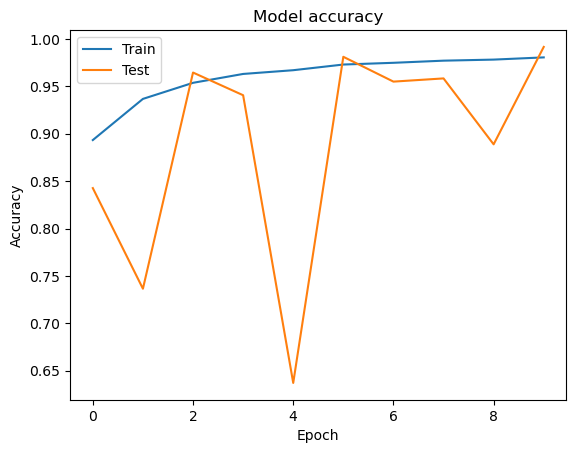

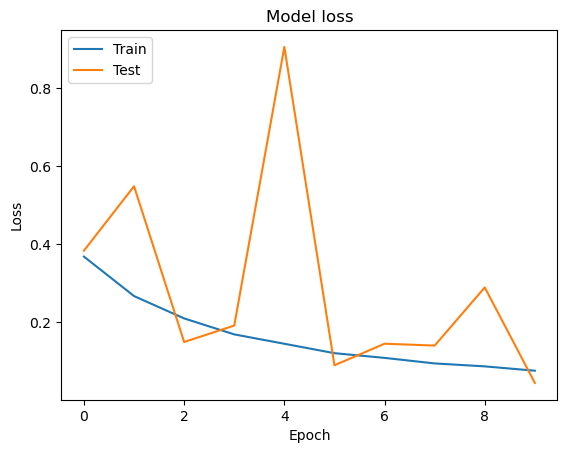

In [16]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [21]:
test_loss, test_accuracy = model.evaluate(validation_generator, steps=len(validation_generator))
print("Test accuracy:", test_accuracy)
print("Test loss:", test_loss)


111/111 [==============================] - 5s 40ms/step - loss: 0.0432 - accuracy: 0.9916
Test accuracy: 0.9915540814399719
Test loss: 0.0432121567428112


In [22]:
def predict_and_show_image(model, image_path, target_size=(64, 64)):
    # Load and display the image
    img = load_img(image_path, target_size=target_size)
    plt.imshow(img)
    plt.axis('off')

    # Resize for model prediction
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Make a prediction
    prediction = model.predict(img_array)

    # Determine the predicted class
    predicted_class = 'Vehicle' if prediction[0][0] > 0.5 else 'Non-Vehicle'

    # Show the predicted class
    plt.title(f"Predicted class: {predicted_class}")
    plt.show()

    return prediction

1/1 [==============================] - 0s 69ms/step


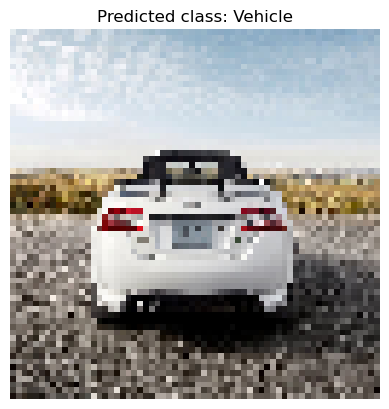

In [26]:
new_image_path = 'car.jpeg'
prediction = predict_and_show_image(model, new_image_path)


1/1 [==============================] - 0s 72ms/step


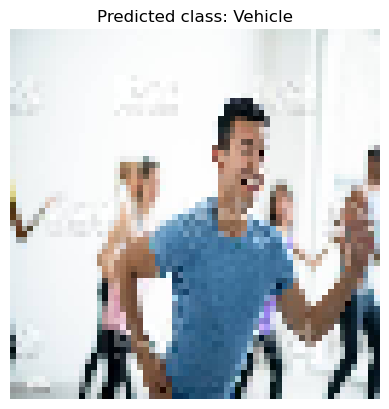

In [24]:
new_image_path = 'simu_liu.jpg'
prediction = predict_and_show_image(model, new_image_path)
